In [51]:

import pandas 
import numpy as np 
import os
import matplotlib.pyplot as mathPlot
import seaborn as sea
import difflib 
#define a class to help us with the process
class ModelFileHelper(object):
    """Ayuda a dar una descripcion de un fichero y a su carga """
    def __init__(self, csvFile):
     self.csvFile= pandas.read_csv(csvFile)
     self.fileName=csvFile
    def getDescription(self):
        return self.csvFile.describe()

    def getModelTypeDetail(self):
        """Retorna una estructura legible con los tipos de dato del conjunto de datos del csv cargado"""
        return self.__translateTypestoHumanReadable(self.csvFile.dtypes)

    def findDifferences(self, other):
        """Retorna una lista con la comparacion de las columnas y los tipos de dos csv"""
        returnlist = list (difflib.Differ().compare(self.getModelTypeDetail().to_string().splitlines(1), other.getModelTypeDetail().to_string().splitlines(1)))
        returnlist.append("Comparativa de tamaños: ")
        returnlist.append (self.fileName +  " Filas:" + ''.join(self.__tuplaCleanUp(self.csvFile.shape[0:1])) + " Columnas:" +  ''.join(self.__tuplaCleanUp(self.csvFile.shape[1:2])))
        returnlist.append (other.fileName + " Filas:" + ''.join(self.__tuplaCleanUp(other.csvFile.shape[0:1])) + " Columnas:" +  ''.join(self.__tuplaCleanUp(other.csvFile.shape[1:2])))
        return returnlist

    def exportHarmonizatedModel(self, harmonizationMatrix, harmonizationquery, fileName):
        """Exporta el modelo tras armonizar los valores en funcion de una matriz de armonización dada y una query"""
        harmonizated =self.csvFile 
        dataframe = pandas.DataFrame(harmonizationMatrix)
        for index, trainedRow in dataframe.iterrows() :
            group =harmonizated.query(harmonizationquery) 
            for index, groupRow in  group.iterrows():
                randomVal= np.random.randint(trainedRow['Min'], trainedRow['Max'])
                harmonizated.loc[(harmonizated.PassengerId  ==  groupRow.PassengerId) , "Age"]=randomVal
        #dump to csv
        print ("volcando a archivo harmonizated_train.csv")
        harmonizated.to_csv(fileName,  index=False)  


    def __tuplaCleanUp(self, tupla):
        result = str(tupla).replace('(','').replace(')','').replace(',','')
        return result

    def __translateTypestoHumanReadable(self, text):
        return text.replace("int64", "Numero").replace("object", "Cadena de texto AlfaNumerica").replace("float64", "Numero (largo)")



#load the train model and store it in a dictionary :
files = { "train" : ModelFileHelper("dataInputs/train.csv"), "test" :   ModelFileHelper("dataInputs/test.csv")} 
 
#describe both files 
print ("*****************************************************************")
print ("Análisis comparativo de tipos")
print ("*****************************************************************")
for index, (clave, valor) in enumerate (files.items()):
    print ("...............................................................")
    print ("File: " + valor.fileName)
    print (valor.getModelTypeDetail())
print ("----------------------------------------------------------------")
print ("Buscando diferencias entre tipos: - Significa eliminado, + significa añadido:")   
for listItem in enumerate (files.get("train").findDifferences(files.get("test"))):
    print (listItem)
#check for null fields:
print ("*****************************************************************")
print ("Buscando campos vacios:")   
print ("*****************************************************************")
for index, (clave, valor) in enumerate (files.items()):
    print ("...............................................................")
    print ("File: " + valor.fileName)
    valor.csvFile.info()
    print (valor.getDescription())  


*****************************************************************
Análisis comparativo de tipos
*****************************************************************
...............................................................
File: dataInputs/train.csv
PassengerId                          Numero
Survived                             Numero
Pclass                               Numero
Name           Cadena de texto AlfaNumerica
Sex            Cadena de texto AlfaNumerica
Age                          Numero (largo)
SibSp                                Numero
Parch                                Numero
Ticket         Cadena de texto AlfaNumerica
Fare                         Numero (largo)
Cabin          Cadena de texto AlfaNumerica
Embarked       Cadena de texto AlfaNumerica
dtype: object
...............................................................
File: dataInputs/test.csv
PassengerId                          Numero
Pclass                               Numero
Name           Cadena de te

In [53]:
#Correlations
print ("*****************************************************************")
print ("Limpieza del modelo: análisis de las correlaciones ")   
print ("*****************************************************************")
files.get("train").csvFile.corr()




*****************************************************************
Limpieza del modelo: análisis de las correlaciones 
*****************************************************************


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [55]:
#Clean up Cabin & embarked Columns
print ("*****************************************************************")
print ("Limpieza del modelo: Eliminando campos Irrelevantes ")   
print ("*****************************************************************")
for index, (clave, valor) in enumerate (files.items()):
    print ("...............................................................")
    print ("File: " + valor.fileName)
    print ("Removing Column Cabin: ")
    valor.csvFile.drop('Cabin', axis=1, inplace=True)
    print ("Removing Column Embarked: ")
    valor.csvFile.drop('Embarked', axis=1, inplace=True)
    print (valor.getModelTypeDetail())  


*****************************************************************
Limpieza del modelo: Eliminando campos Irrelevantes 
*****************************************************************
...............................................................
File: dataInputs/train.csv
Removing Column Cabin: 


KeyError: "['Cabin'] not found in axis"

In [58]:
#Infer missing age Data
print ("*****************************************************************")
print ("Limpieza del modelo: Inferir campos de Edad vacios:")   
print ("*****************************************************************") 
files.get("train").csvFile.query('Age >=1').groupby(['Survived','Pclass', 'Sex']).agg({'Age': ['mean', 'min', 'max']})

*****************************************************************
Limpieza del modelo: Inferir campos de Edad vacios:
*****************************************************************


Age            
                             mean   min   max
Survived Pclass Sex                          
0        1      female  25.666667   2.0  50.0
                male    44.581967  18.0  71.0
         2      female  36.000000  24.0  57.0
                male    33.369048  16.0  70.0
         3      female  23.818182   2.0  48.0
                male    27.255814   1.0  74.0
1        1      female  34.939024  14.0  63.0
                male    37.153846   4.0  80.0
         2      female  28.080882   2.0  55.0
                male    19.833333   1.0  62.0
         3      female  20.155556   1.0  63.0
                male    22.864865   1.0  45.0

In [60]:
#Comparative of age groups between train model and test model
print ("*****************************************************************")
print ("Limpieza del modelo: comparacion de grupos de edad :")   
print ("*****************************************************************") 
print ("modelo Train:")
files.get("train").csvFile.query('Age >=1').groupby(['Pclass', 'Sex']).agg({'Age': ['mean', 'min', 'max']})

*****************************************************************
Limpieza del modelo: comparacion de grupos de edad :
*****************************************************************
modelo Train:


Age           
                    mean  min   max
Pclass Sex                         
1      female  34.611765  2.0  63.0
       male    41.685000  4.0  80.0
2      female  28.722973  2.0  57.0
       male    31.677083  1.0  70.0
3      female  22.170000  1.0  63.0
       male    26.611111  1.0  74.0

In [62]:
#imp
print ("modelo test:")
files.get("test").csvFile.query('Age >=1').groupby(['Pclass', 'Sex']).agg({'Age': ['mean', 'min', 'max']})


modelo test:


Age            
                    mean   min   max
Pclass Sex                          
1      female  40.820000  14.0  76.0
       male    40.508772   6.0  68.0
2      female  26.200000   1.0  60.0
       male    31.150794   2.0  63.0
3      female  24.437500   1.0  47.0
       male    30.243151   3.0  72.0

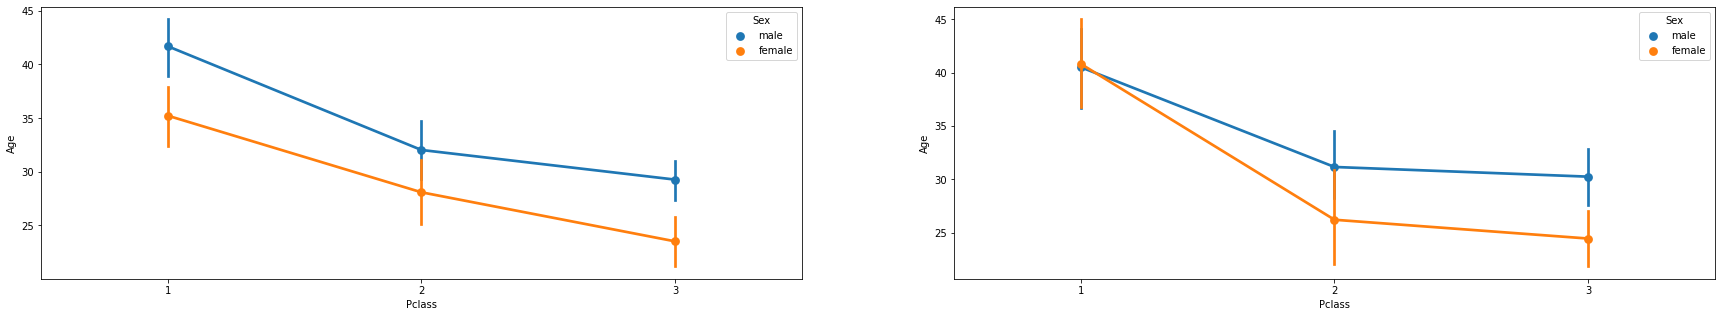

In [63]:
fig, axs = mathPlot.subplots(ncols=2, figsize=(30,5))
sea.pointplot(x="Pclass", y="Age", hue="Sex", data=  files.get("train").csvFile.query('Age >= 1'), ax=axs[0])
sea.pointplot(x="Pclass", y="Age", hue="Sex", data=  files.get("test").csvFile.query('Age >= 1'), ax=axs[1])

In [64]:
print ("*****************************************************************")
print ("Limpieza del modelo: corrección de la edad :")   
print ("*****************************************************************") 
print ("modelo Train:")
estadisticasTrain= files.get("train").csvFile.query('Age >=1').groupby(['Survived','Pclass', 'Sex']).agg({'Age': ['mean', 'min', 'max']})
#ya vamos a trabajar con un modelo exportable usando las estadisticas obtenidas con anterioridad 
#Survived	Pclass	Sex			mean	min		max
#0			1		female	25.666667	2.0		50.0
#0			1		male	44.581967	18.0	71.0
#0			2		female	36.000000	24.0	57.0
#0			2		male	33.369048	16.0	70.0
#0			3		female	23.818182	2.0		48.0
#0			3		male	27.255814	1.0		74.0
#1			1		female	34.939024	14.0	63.0
#1			1		male	37.153846	4.0		80.0
#1			2		female	28.080882	2.0		55.0
#1			2		male	19.833333	1.0		62.0
#1			3		female	20.155556	1.0		63.0
#1			3		male	22.864865	1.0		45.0

estadisticasTrain = [{'Survived':0,'Pclass':1,'Sex':'female','Min':2,'Max':50},
{'Survived':0,'Pclass':1,'Sex':'male','Min':18,'Max':71},
{'Survived':0,'Pclass':2,'Sex':'female','Min':24,'Max':57},
{'Survived':0,'Pclass':2,'Sex':'male','Min':16,'Max':70},
{'Survived':0,'Pclass':3,'Sex':'female','Min':2,'Max':48},
{'Survived':0,'Pclass':3,'Sex':'male','Min':1,'Max':74},
{'Survived':1,'Pclass':1,'Sex':'female','Min':14,'Max':63},
{'Survived':1,'Pclass':1,'Sex':'male','Min':4,'Max':80},
{'Survived':1,'Pclass':2,'Sex':'female','Min':2,'Max':55},
{'Survived':1,'Pclass':2,'Sex':'male','Min':1,'Max':62},
{'Survived':1,'Pclass':3,'Sex':'female','Min':1,'Max':63},
{'Survived':1,'Pclass':3,'Sex':'male','Min':1,'Max':45}]
#Usamos las funciones de exportación que realizan van a completar los valores faltantes con valores aleatorios entre
#el máximo y el minimo de la matriz de armonizacion. 
files.get("train").exportHarmonizatedModel(estadisticasTrain,
'(@pandas.isnull(Age) or (Age < 1)) and (Survived == @trainedRow.Survived) and (Pclass == @trainedRow.Pclass) and (Sex == @trainedRow.Sex)', 
"harmonizated_train.csv" )

files.get("test").exportHarmonizatedModel(estadisticasTrain,
'(@pandas.isnull(Age) or (Age < 1)) and (Pclass == @trainedRow.Pclass) and (Sex == @trainedRow.Sex)', 
"harmonizated_test.csv" )



*****************************************************************
Limpieza del modelo: corrección de la edad :
*****************************************************************
modelo Train:
volcando a archivo harmonizated_train.csv
volcando a archivo harmonizated_train.csv
